In [240]:
import pandas as pd
from nltk.corpus import inaugural
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

/Users/slevin886/anaconda2/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [79]:
df = pd.read_csv('./PresidentialDataFrame.csv', index_col=0)

In [80]:
#not used
df.drop('Wiki References', axis=1, inplace=True)

In [81]:
df.tail()

,First Year of Presidency,President Name,Wiki Content,Num Wiki References,Words on Page
39,1989,George H. W. Bush,"George Herbert Walker Bush (born June 12, 1924...",344,88238
40,1993,Bill Clinton,"William Jefferson ""Bill"" Clinton (born William...",392,73712
41,2001,George W. Bush,"George Walker Bush (born July 6, 1946) is an A...",787,88626
42,2009,Barack Hussein Obama,Barack Hussein Obama II ( ( listen); born Augu...,882,84498
43,2017,Donald Trump,"Donald John Trump (born June 14, 1946) is the ...",726,88048


In [82]:
#accessing the inaugural addresses of all Presidents
addresses = {}
for file in inaugural.fileids():
    if file in ['1825-Adams.txt', '1933-Roosevelt.txt', '1937-Roosevelt.txt', '1941-Roosevelt.txt', '1945-Roosevelt.txt',
               '2001-Bush.txt', '2005-Bush.txt',  '1889-Harrison.txt', '1965-Johnson.txt']:
        name = file[5:-4] + '2'
        if name in addresses:
            addresses[name] += list(inaugural.words(file))
        else:
            addresses[name] = list(inaugural.words(file))
    else:
        name = file[5:-4]
        if name in addresses:
            addresses[name] += list(inaugural.words(file))
        else:
            addresses[name] = list(inaugural.words(file))

In [83]:
#Missing Trump's first and Obama's second- adding them here
obama = open('./obama2.txt').read()
obama = obama.split()
addresses['Obama'].extend(obama)

trump = open('./trump_in.txt').read()
trump = trump.split()
addresses['Trump'] = trump

In [84]:
#getting last names to merge on
last_names = [val.split()[-1] for val in df['President Name']]
cleaned = []
for val in last_names:
    if val not in cleaned:
        cleaned.append(val)
    else:
        val = val + '2'
        cleaned.append(val)

In [85]:
df['for_merge'] = cleaned

In [86]:
#making a df to merge
address = pd.DataFrame()
address['Inaugural'] = list(addresses.values())
address['name'] = list(addresses.keys())

In [87]:
#Presidents that never delivered an inaugural address
set(df['for_merge']) - set(address['name'])

{'Arthur', 'Buren', 'Fillmore', 'Ford', 'Johnson', 'Tyler'}

In [88]:
df = pd.merge(df, address, how='left', left_on='for_merge', right_on='name')

In [89]:
#dropping redundant name columns
df.drop(['name', 'for_merge'], axis=1, inplace=True)

In [90]:
#getting birth and death years
birth = []
death = []

for val in df['Wiki Content']:
    births = re.search(r'\d{4}', val)
    birth.append(births.group(0))
    deaths = re.search('\d{4}(?=\))', val)
    death.append(deaths.group(0))
    
df['birth_year'] = birth
df['death_year'] = death

#changing Presidents who are still alive to Null
df.loc[df.birth_year == df.death_year, 'death_year'] = np.nan

In [91]:
#creating life span
df['years_lived'] = df['death_year'].fillna(0).astype(int) - df['birth_year'].astype(int)
df.loc[df['years_lived'] < 0, 'years_lived'] = np.nan

In [92]:
#converting data type
df['birth_year'] = df['birth_year'].astype(int)

In [173]:
#age became president
df['age_become_pres'] = df['First Year of Presidency'] - df['birth_year']

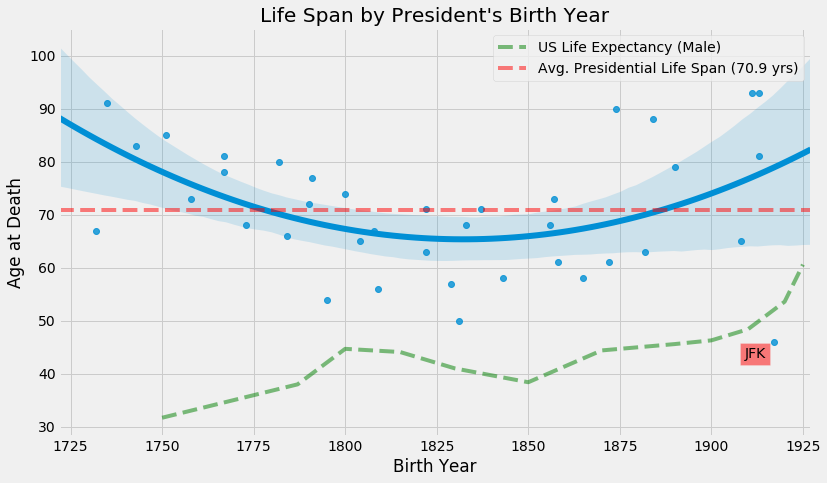

In [177]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))

sns.regplot(df['birth_year'], df['years_lived'], order=2)
plt.plot([1750, 1787, 1800, 1815, 1830, 1850, 1870, 1890, 1900, 1910, 1920, 1925] ,
         [31.7, 38, 44.7, 44.1, 41, 38.4, 44.4, 45.6, 46.3, 48.4, 53.6, 60.6], c='g', linestyle='dashed', alpha=0.5,
        label='US Life Expectancy (Male)')
plt.title('Life Span by President\'s Birth Year')
plt.ylabel('Age at Death')
plt.xlabel('Birth Year')
plt.axhline(df['years_lived'].mean(), color='r', linestyle='dashed', alpha=0.5, label='Avg. Presidential Life Span (70.9 yrs)')
plt.text(1909, 43, 'JFK', bbox=dict(facecolor='red', alpha=0.5))
plt.legend()

In [127]:
#collecting all dates in their wikipedia pages (will eliminate all not w/in 40 yrs of presidency to make robust to other 4 digit #s)
df['dates_in_wiki'] = df['Wiki Content'].apply(lambda x: np.array([np.int(i) for i in re.findall(r'\d{4}', x)]))

In [159]:
#differences between dates in wiki and first year of presidency 
df['date_diffs'] = df['dates_in_wiki']- df['First Year of Presidency']

#only interesed in events that occurred 40 years before/after Presidency (enough time to capture all relevant events)
df['date_diffs'] = df['date_diffs'].apply(lambda x: x[np.abs(x) < 40])

In [181]:
df['years_lived_after_pres'] = (df['years_lived'].fillna(0) + df['birth_year']) - df['First Year of Presidency']
df.loc[df['years_lived_after_pres'] < 0, 'years_lived_after_pres'] = np.nan

In [185]:
#getting the mean of the dates presented in the President's profile and their standard deviation
df['profile_dates_mean'] = df['date_diffs'].apply(lambda x: x.mean())
df['profile_dates_std'] = df['date_diffs'].apply(lambda x: x.std())

In [190]:
df.columns

Index(['First Year of Presidency', 'President Name', 'Wiki Content',
       'Num Wiki References', 'Words on Page', 'Inaugural', 'birth_year',
       'death_year', 'years_lived', 'dates_in_wiki', 'date_diffs',
       'age_become_pres', 'years_lived_after_pres', 'profile_dates_mean',
       'profile_dates_std'],
      dtype='object')

In [207]:
#presidency length
df['presidency_length'] = df['First Year of Presidency'].diff().shift(-1)
#correcting for one non-contiguously serving President
df.loc[df['President Name'] == 'Grover Cleveland', 'presidency_length'] = 8.0

Text(0.5,1,'Page Length as a Function of Time')

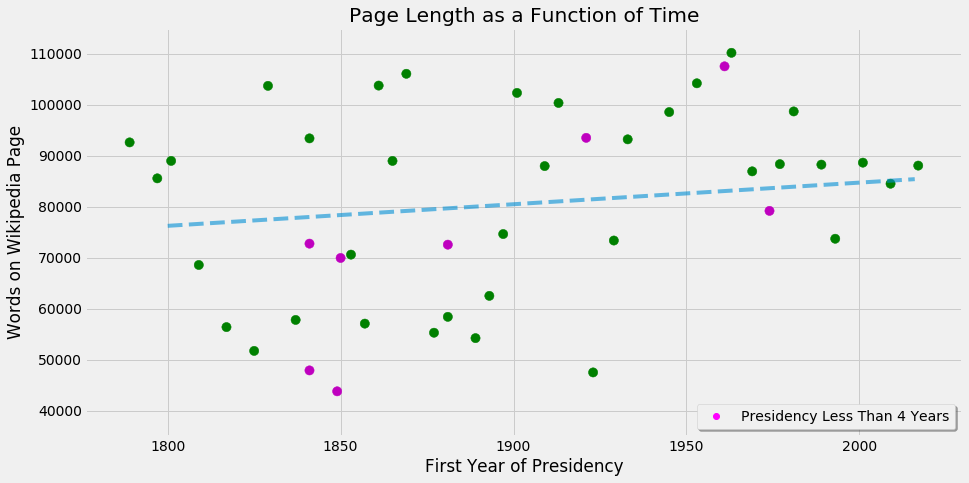

In [277]:
#for line of best fit
ols = sm.OLS(df['Words on Page'], df['First Year of Presidency'].values,).fit()
x = np.array([1800, 1850, 1900, 1950, 2016])
y = ols.params[0] * x

#plotting figure
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(14,7))
ax = plt.plot(x, y, alpha= 0.6, linestyle='dashed')
ax = plt.scatter(df['First Year of Presidency'], df['Words on Page'], c = 
                ['m' if x < 4 else 'g' for x in df['presidency_length']], s=85)
plt.ylim(35000, 115000)
line1 = plt.Line2D(range(1), range(1), color="magenta", marker='o', markerfacecolor="magenta", linewidth=0)
plt.legend(([line1]),(['Presidency Less Than 4 Years']),numpoints=1, loc='lower right', shadow=True)

plt.ylabel('Words on Wikipedia Page')
plt.xlabel('First Year of Presidency')
plt.title('Page Length as a Function of Time')